In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.datagenerator import DataGenerator, DataLoader, z_score
from src.performance_evaluation import compute_PCA, plot_confusion_matrix, plot_PCA
from src.util import plot_voxel

# load vae model
from src.vae import vae_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2024-05-16 08:37:36.448683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.16.1


# Stage 2

**1. Training of the material classificator $\Upsilon$**

**2. Training of the mapper $\Xi$**

## Material classificator $\Upsilon$

**CNN**

In [ ]:
datagenerator = False

params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": True,
    "EIT_shape": "matrix",
}

if datagenerator:

    idx = np.arange(0, len(os.listdir(params["path"])))
    np.random.shuffle(idx)

    limit_index = 100_000

    training_generator = DataGenerator(idx[:limit_index], **params)
    test_____generator = DataGenerator(idx[limit_index:], **params)
    X, Y = training_generator[0]
else:
    X, Y = DataLoader(params)
    X = z_score(X)
    X = np.expand_dims(X, axis=3)
    print(X.shape, Y.shape)

In [ ]:
print(X.shape, Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42
)

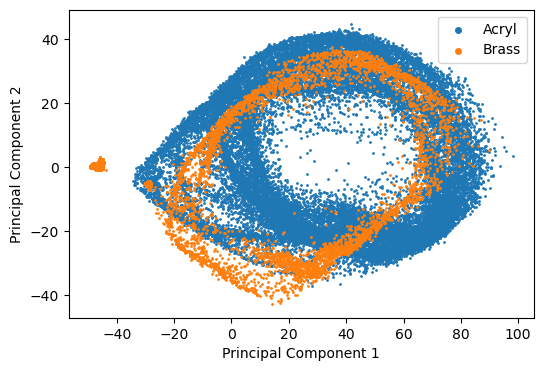

In [6]:
data_pca = compute_PCA(X_train)
plot_PCA(data_pca, Y_train)

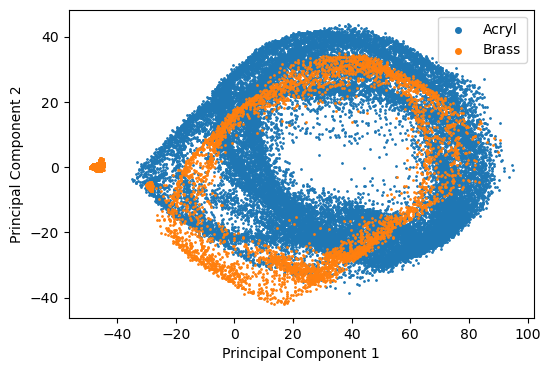

In [7]:
data_pca = compute_PCA(X_test)
plot_PCA(data_pca, Y_test)

In [8]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(62100, 64, 64, 1) (62100, 64, 64, 1) (62100,) (62100,)


In [9]:
def material_classificator_model_CNN(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    # optional aditional layer
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    mapper_input = tf.keras.layers.Input(shape=input_shape)
    # normalize input data
    # x = Xscaler(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


material_classificator_CNN = material_classificator_model_CNN()
material_classificator_CNN.summary()

2024-05-14 09:49:16.009484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
material_classificator_CNN.compile(tf.optimizers.Adam(learning_rate=0.005), loss="mse")

In [11]:
if datagenerator:
    classificator_history_CNN = material_classificator_CNN.fit(
        training_generator, epochs=50, batch_size=128
    )
else:
    classificator_history_CNN = material_classificator_CNN.fit(
        X_train,
        Y_train,
        epochs=20,
        batch_size=params["batch_size"],
    )

material_classificator_CNN.save_weights("models/material_mapper.weights.h5")

Epoch 1/20


I0000 00:00:1715680158.116420  352067 service.cc:145] XLA service 0x7f0e6400b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715680158.116472  352067 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-14 09:49:18.223483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 09:49:18.369014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 93/486 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1093

I0000 00:00:1715680159.552063  352067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0416
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1669e-04
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6511e-04
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7709e-04
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010
Epoch 12/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7167e-04
Epoch 13/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5532e-04
Epoch 14/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7110e-04
Epoch 15/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 

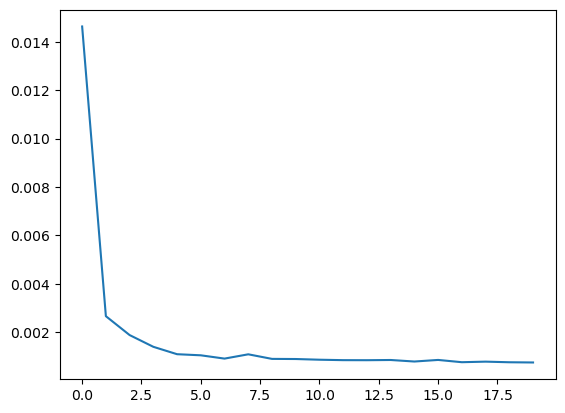

In [12]:
plt.plot(classificator_history_CNN.history["loss"])

In [11]:
Y_pred = np.concatenate(np.round(material_classificator_CNN.predict(X_test)))

1941/1941 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [12]:
s_path = "models/mapper_4/"

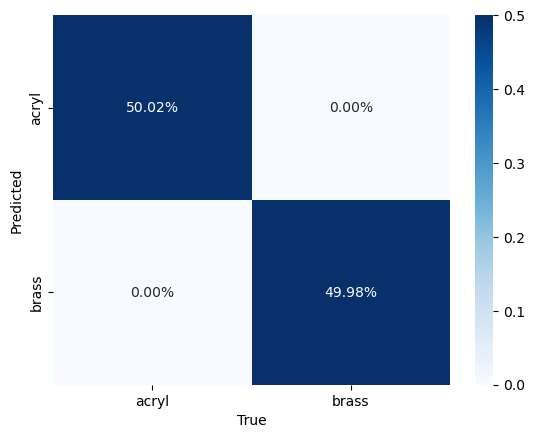

In [13]:
plot_confusion_matrix(Y_test, np.abs(Y_pred), s_path)

In [47]:
# os.mkdir(s_path)
material_classificator_CNN.save(f"{s_path}/model.keras")
np.savez(s_path + "/test_data.npz", X_test=X_test, Y_test=Y_test, params=params)

## Mapper $\Xi$

Loat the VAE model and train the two required mapper.

In [3]:
vae = vae_model()
vae.load_weights("models/vaes/vae_4.weights.h5")
vae.summary()

Φ = vae.encoder
Ψ = vae.decoder

2024-05-16 08:37:55.196592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        11,039 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        11,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,506 (87.91 KB)

 Trainable params: 22,444 (87.67 KB)

 Non-trainable params: 62 (248.00 B)

In [4]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "EIT_shape": "matrix",
    "supervised": "anomaly_and_material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": False,
}

In [5]:
X,Y,m = DataLoader(params)

X = z_score(X)
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=4)

100%|██████████| 124200/124200 [49:06<00:00, 42.15it/s] 


In [6]:
X_train, X_test, gamma_train, gamma_test, m_train, m_test = train_test_split(
    X, Y, m, test_size=0.1, random_state=42
)
# del X,Y,m

In [7]:
_,_,z_train = Φ.predict(gamma_train)

2024-05-16 09:57:06.316939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29302456320 exceeds 10% of free system memory.
2024-05-16 09:58:17.477137: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29302456320 exceeds 10% of free system memory.
I0000 00:00:1715853509.672946  584090 service.cc:145] XLA service 0x7f5848008fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715853509.673018  584090 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-16 09:58:29.719101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-16 09:58:29.810103: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  16/3494 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step  

I0000 00:00:1715853510.413295  584090 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3494/3494 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


In [8]:
_,_,z_test = Φ.predict(gamma_test)

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [10]:
print(X_train.shape, gamma_train.shape, m_train.shape, z_train.shape)
print(X_test.shape, gamma_test.shape, m_test.shape, z_test.shape)

(111780, 64, 64, 1) (111780, 32, 32, 32, 1) (111780,) (111780, 8)
(12420, 64, 64, 1) (12420, 32, 32, 32, 1) (12420,) (12420, 8)


In [22]:
def mapper_CNN(input_shape=(64, 64, 1), latent_dim=8, kernel=3):
    mapper_input = tf.keras.layers.Input(shape=input_shape)
    
    Model = 1
    if Model == 1:
        x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(
           mapper_input
        )
        x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
        x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
        x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
    if Model == 2:
        x = tf.keras.layers.Flatten()(mapper_input)
        x = tf.keras.layers.Dense(256, activation="linear")(x)
        x = tf.keras.layers.Dense(64, activation="linear")(x)
        x = tf.keras.layers.Dense(16, activation="linear")(x)
    if Model == 3:
        x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(
           mapper_input
        )
        x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation="linear")(x)
        x = tf.keras.layers.Dense(64, activation="linear")(x)
        x = tf.keras.layers.Dense(16, activation="linear")(x)
    
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)

Ξ = mapper_CNN()
Ξ.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
Ξ.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,672 (18.25 KB)

 Trainable params: 4,672 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = Ξ.fit(X_train, z_train, batch_size=256, epochs=100)

Epoch 1/100
433/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1327

I0000 00:00:1715855423.580023  598870 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_561', 4 bytes spill stores, 4 bytes spill loads



437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1323
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0876
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0806
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0760
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0727
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0702
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0688
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0673
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0663
Epoch 10/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0654
Epoch 11/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0643
Epoch 12/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0633
Epoch 13/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0623
Epoch 14/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0615
Epoch 15/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

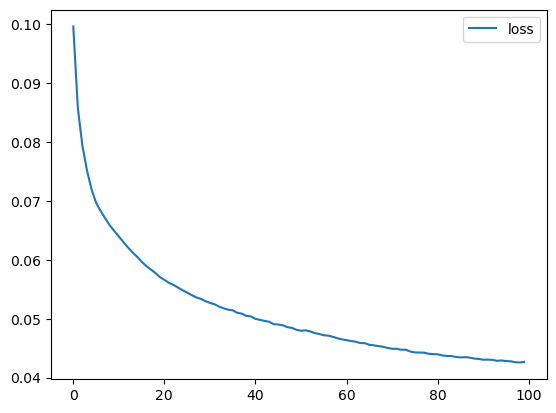

In [24]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

**Test the mapper $\Xi$ performance**

In [25]:
γ_hat = Ψ.predict(Ξ.predict(X_test))
print(γ_hat.shape)

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(12420, 32, 32, 32, 1)


In [26]:
np.min(γ_hat[0,:,:,:,0]),np.max(γ_hat[0,:,:,:,0])

(-0.39272457, -0.1573887)

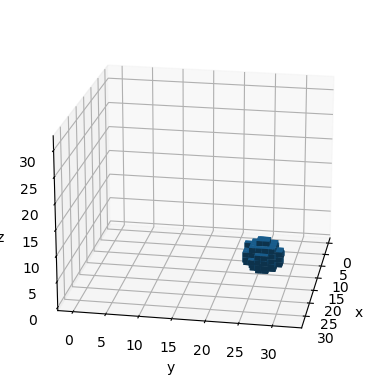

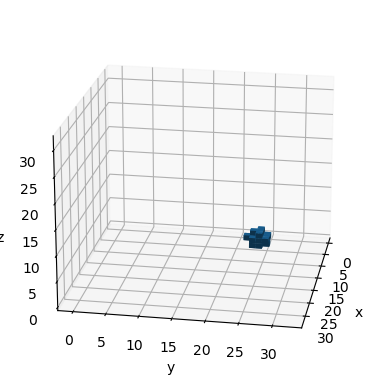

---------


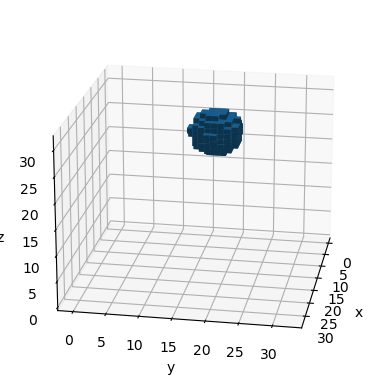

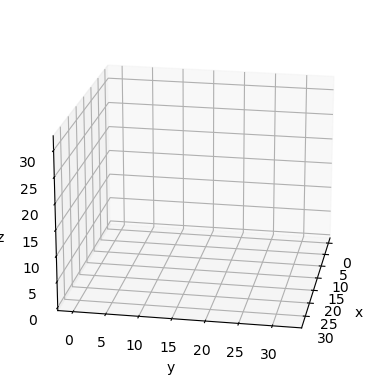

---------


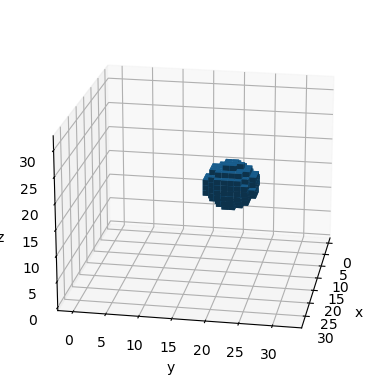

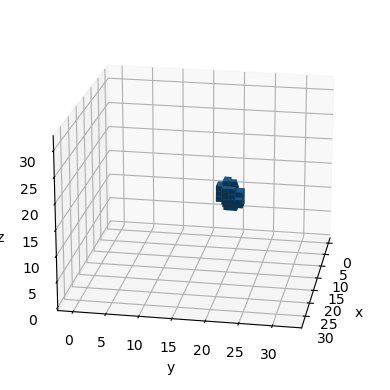

---------


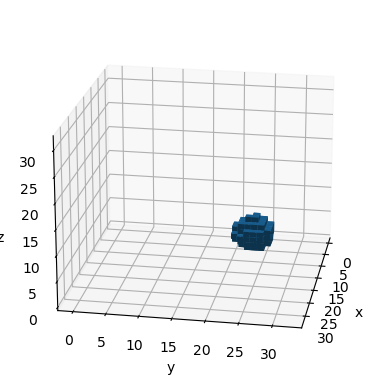

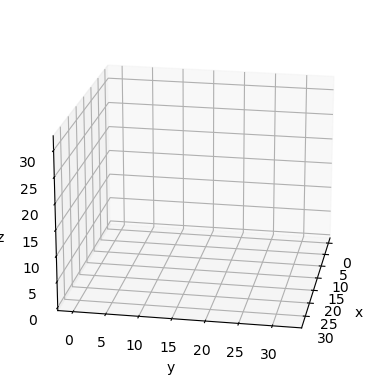

---------


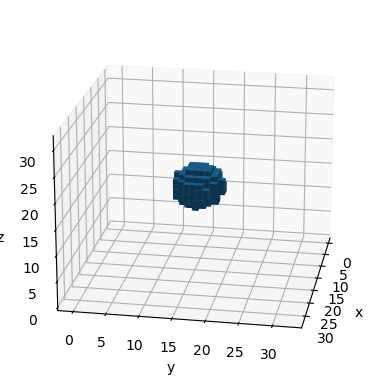

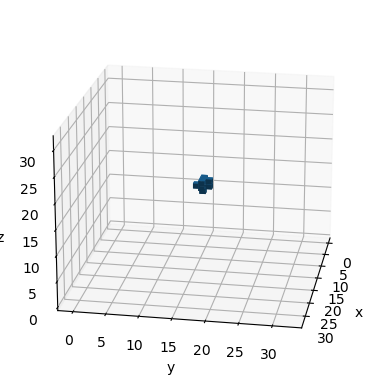

---------


In [28]:
for rdn in np.random.randint(low=0, high=γ_hat.shape[0], size=5):
    plot_voxel(gamma_test[rdn,:,:,:,0])
    
    sgl_pred = γ_hat[rdn, :, :, :, 0]
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    sgl_pred = np.round(sgl_pred, 1) + 0.35  #  round offset
    sgl_pred = np.round(sgl_pred)
    sgl_pred = sgl_pred
    plot_voxel(sgl_pred)
    print("---------")

In [ ]:
mapper.save_weights("models/mapper.weights.h5")

In [25]:
np.savez("models/testdata_stage3.npz", 
         gamma_test = gamma_test,
         z_test= z_test,
         X_test = X_test,
         m_test = m_test,
        )

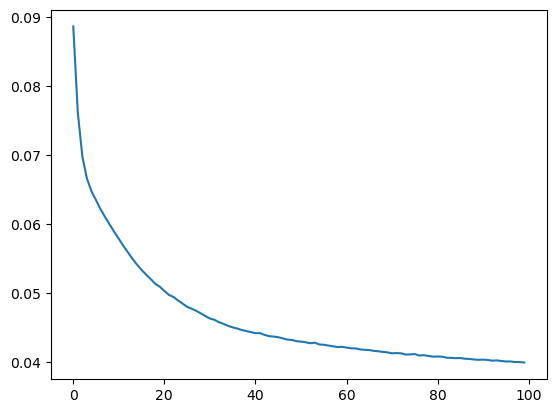

In [26]:
plt.plot(history.history["loss"])